**Loading Pre-trained VGG16 Model for Image Feature Extraction in Keras:**

In [ ]:

from tensorflow import keras
from tensorflow.keras import layers

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

**Summary of the model:**

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**Downloading the Dataset:**

In [ ]:
!rm -rf cats_vs_dogs_small sample_data train

In [ ]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

Saving kaggle.json to kaggle (8).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
401 - Unauthorized
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace test1.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace train.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y


**Creating Subsets of Cats vs. Dogs Image Data for Training, Test and Validation:**

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train10", start_index=0, end_index=1000)
make_subset("validation10", start_index=1000, end_index=1500)
make_subset("test10", start_index=1500, end_index=2000)

#Re-shaping the images
Creating TensorFlow Datasets for Image Classification

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train10",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation10",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test10",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


**Feature Extraction from Image Datasets Using VGG16 Convolutional Base:**

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)


1/1 [==============================] - 0s 21ms/step


In [ ]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**.      

Building and Training a Binary Classification Model with Feature Extraction

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras.h5",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=6,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)




Epoch 1/6
63/63 [==============================] - 1s 8ms/step - loss: 11.1081 - accuracy: 0.9285 - val_loss: 3.8804 - val_accuracy: 0.9710
Epoch 2/6
63/63 [==============================] - 0s 4ms/step - loss: 4.7420 - accuracy: 0.9715 - val_loss: 7.8944 - val_accuracy: 0.9560
Epoch 3/6
63/63 [==============================] - 19s 301ms/step - loss: 0.9751 - accuracy: 0.9895 - val_loss: 3.4426 - val_accuracy: 0.9740
Epoch 4/6
63/63 [==============================] - 0s 5ms/step - loss: 1.4695 - accuracy: 0.9890 - val_loss: 3.3254 - val_accuracy: 0.9790
Epoch 5/6
63/63 [==============================] - 0s 4ms/step - loss: 1.0472 - accuracy: 0.9885 - val_loss: 3.3912 - val_accuracy: 0.9800
Epoch 6/6
63/63 [==============================] - 0s 4ms/step - loss: 0.3010 - accuracy: 0.9965 - val_loss: 4.6875 - val_accuracy: 0.9760


**Plotting the results:**

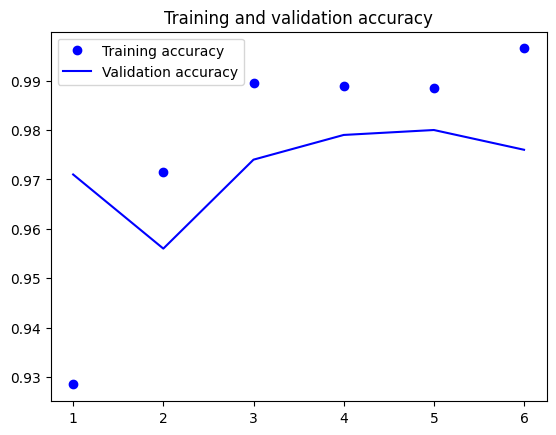

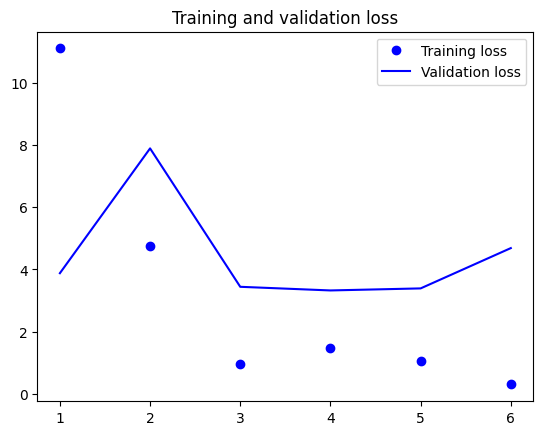

In [ ]:

import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


**Feature extraction together with data augmentation**:


Configuring VGG16 Convolutional Base for Transfer Learning

In [ ]:

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False


** Trainable weights before and after freezing:**

In [ ]:


conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))


This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))


This is the number of trainable weights after freezing the conv base: 0


# **Data Augumentation:**

In [ ]:

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.9)(x)
x = layers.Dropout(0.6)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=6,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/6
63/63 [==============================] - 4s 35ms/step - loss: 52.4524 - accuracy: 0.6650 - val_loss: 3.8961 - val_accuracy: 0.9610
Epoch 2/6
63/63 [==============================] - 2s 31ms/step - loss: 35.6851 - accuracy: 0.7665 - val_loss: 3.5324 - val_accuracy: 0.9640
Epoch 3/6
63/63 [==============================] - 2s 31ms/step - loss: 31.1670 - accuracy: 0.8030 - val_loss: 3.4110 - val_accuracy: 0.9670
Epoch 4/6
63/63 [==============================] - 2s 28ms/step - loss: 28.7814 - accuracy: 0.8030 - val_loss: 4.4938 - val_accuracy: 0.9640
Epoch 5/6
63/63 [==============================] - 2s 28ms/step - loss: 27.1544 - accuracy: 0.8045 - val_loss: 4.5868 - val_accuracy: 0.9620
Epoch 6/6
63/63 [==============================] - 2s 28ms/step - loss: 23.8002 - accuracy: 0.8335 - val_loss: 5.5762 - val_accuracy: 0.9570


**Evaluating a Pre-trained Model on the Test Dataset:**

In [ ]:

test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")



32/32 [==============================] - 1s 17ms/step - loss: 4.0232 - accuracy: 0.9670
Test accuracy: 0.967


**Fine-tuning a pretrained model:**

In [ ]:


conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last:**

In [ ]:


conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False


**Fine-tuning the model:**

In [ ]:


model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=6,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/6
63/63 [==============================] - 4s 33ms/step - loss: 9.7957 - accuracy: 0.8590 - val_loss: 1.6982 - val_accuracy: 0.9660
Epoch 2/6
63/63 [==============================] - 2s 30ms/step - loss: 3.9978 - accuracy: 0.8350 - val_loss: 1.0912 - val_accuracy: 0.9630
Epoch 3/6
63/63 [==============================] - 2s 30ms/step - loss: 2.3782 - accuracy: 0.8185 - val_loss: 0.7169 - val_accuracy: 0.9510
Epoch 4/6
63/63 [==============================] - 2s 30ms/step - loss: 1.2474 - accuracy: 0.8050 - val_loss: 0.4027 - val_accuracy: 0.9460
Epoch 5/6
63/63 [==============================] - 2s 38ms/step - loss: 0.8200 - accuracy: 0.7865 - val_loss: 0.3108 - val_accuracy: 0.9470
Epoch 6/6
63/63 [==============================] - 2s 30ms/step - loss: 0.6553 - accuracy: 0.7695 - val_loss: 0.2668 - val_accuracy: 0.9270


**Testing tuned model in test test:**

Evaluating a Fine-Tuned Model on the Test Dataset

In [ ]:
model = keras.models.load_model("fine_tuning.keras.h5")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 17ms/step - loss: 0.3409 - accuracy: 0.9240
Test accuracy: 0.924


### **CNN MODEL**

In [ ]:
#Creating Subsets of Cats vs. Dogs Image Data for Training and Validation
import os, shutil

original_dir = "train"  # Original directory containing the images
new_base_dir = "cats_vs_dogs_small"  # New base directory for the subsets

# Function to create a subset
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = os.path.join(new_base_dir, subset_name, category)
        os.makedirs(dir, exist_ok=True)  # Use exist_ok to avoid errors if the directory already exists
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            src = os.path.join(original_dir, fname)
            dst = os.path.join(dir, fname)
            shutil.copyfile(src, dst)

# Create subsets
make_subset("train14", start_index=0, end_index=1000)
make_subset("validation14", start_index=1000, end_index=1500)
make_subset("test14", start_index=1500, end_index=2000)

**Building the Model**

In [ ]:

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=34, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=46, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=76, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=124, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=200, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

**Summary:**

In [ ]:
model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_55 (Conv2D)          (None, 178, 178, 34)      952       
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 89, 89, 34)        0         
 ng2D)                                                           
                                                                 
 conv2d_56 (Conv2D)          (None, 87, 87, 46)        14122     
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 43, 43, 46)        0         
 ng2D)                                                    

In [ ]:

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Creating TensorFlow Datasets for Image Classification :**

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
from pathlib import Path

# Define paths using pathlib.Path
new_base_dir = Path("cats_vs_dogs_small")
train_dataset = image_dataset_from_directory(
    new_base_dir / "train14",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation14",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test14",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data:**

In [ ]:


for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the Model:**

In [ ]:


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/15
94/94 [==============================] - 3s 18ms/step - loss: 0.6993 - accuracy: 0.5073 - val_loss: 0.6884 - val_accuracy: 0.5805
Epoch 2/15
94/94 [==============================] - 2s 16ms/step - loss: 0.6774 - accuracy: 0.5900 - val_loss: 0.7213 - val_accuracy: 0.5450
Epoch 3/15
94/94 [==============================] - 2s 16ms/step - loss: 0.6317 - accuracy: 0.6330 - val_loss: 0.5910 - val_accuracy: 0.6850
Epoch 4/15
94/94 [==============================] - 2s 16ms/step - loss: 0.6017 - accuracy: 0.6733 - val_loss: 0.6103 - val_accuracy: 0.6545
Epoch 5/15
94/94 [==============================] - 2s 16ms/step - loss: 0.5497 - accuracy: 0.7240 - val_loss: 0.5942 - val_accuracy: 0.6975
Epoch 6/15
94/94 [==============================] - 2s 16ms/step - loss: 0.5019 - accuracy: 0.7513 - val_loss: 0.5071 - val_accuracy: 0.7520
Epoch 7/15
94/94 [==============================] - 2s 17ms/step - loss: 0.4656 - accuracy: 0.7660 - val_loss: 0.4587 - val_accuracy: 0.7865
Epoch 8/15
94

**curves of loss and accuracy during training:**

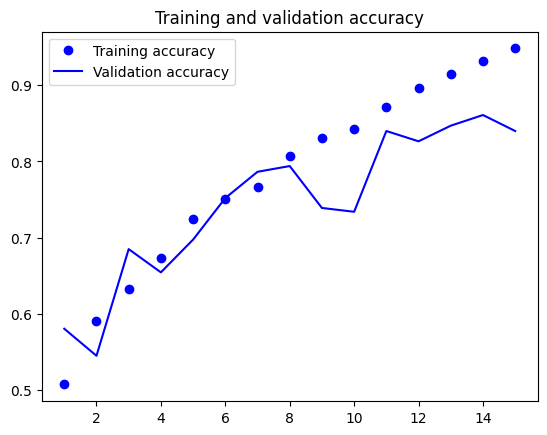

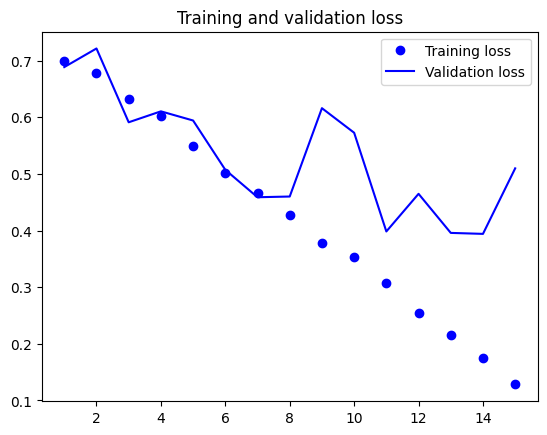

In [ ]:


import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 7ms/step - loss: 0.6520 - accuracy: 0.7585
Test accuracy: 0.758


**Data Augmentation:**

In [ ]:


data_augmentation = keras.Sequential(
    [
       layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.00089),
        layers.RandomZoom(0.0009),
    ]
)

**New convnet that includes image augmentation and dropout:**

In [ ]:

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=2,strides=(1, 1), activation="relu",padding='same')(x)
x = layers.MaxPooling2D(pool_size=1)(x)
x = layers.Conv2D(filters=45, kernel_size=2,strides=(1, 1), activation="relu",padding='same')(x)
x = layers.MaxPooling2D(pool_size=12)(x)
x = layers.Conv2D(filters=103, kernel_size=2,strides=(1, 1), activation="relu",padding='same')(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=176, kernel_size=2,strides=(1, 1), activation="relu",padding='same')(x)
x = layers.MaxPooling2D(pool_size=1)(x)
x = layers.Conv2D(filters=210, kernel_size=2,strides=(1, 1), activation="relu",padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the convnet:**

In [ ]:

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=7,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/7
94/94 [==============================] - 5s 24ms/step - loss: 0.6860 - accuracy: 0.5523 - val_loss: 0.6755 - val_accuracy: 0.5545
Epoch 2/7
94/94 [==============================] - 2s 22ms/step - loss: 0.6533 - accuracy: 0.6203 - val_loss: 0.7279 - val_accuracy: 0.5665
Epoch 3/7
94/94 [==============================] - 2s 22ms/step - loss: 0.6044 - accuracy: 0.6703 - val_loss: 0.5476 - val_accuracy: 0.7350
Epoch 4/7
94/94 [==============================] - 2s 22ms/step - loss: 0.5437 - accuracy: 0.7243 - val_loss: 0.5970 - val_accuracy: 0.6955
Epoch 5/7
94/94 [==============================] - 2s 23ms/step - loss: 0.4934 - accuracy: 0.7623 - val_loss: 0.5185 - val_accuracy: 0.7330
Epoch 6/7
94/94 [==============================] - 2s 22ms/step - loss: 0.4640 - accuracy: 0.7843 - val_loss: 0.4511 - val_accuracy: 0.7930
Epoch 7/7
94/94 [==============================] - 2s 22ms/step - loss: 0.4293 - accuracy: 0.7990 - val_loss: 0.5888 - val_accuracy: 0.7210


#Evaluating the model on the test set

In [ ]:


test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 9ms/step - loss: 0.5001 - accuracy: 0.7645
Test accuracy: 0.765
